#**Reconhecimento de Padrões**

*Trabalho 1: Classificadores K-NN e Nearet Prototype Classifier com K-Fold*

*- Renoir Sampaio (389113)*

In [ ]:
# Importando bibliotecas
import numpy as np # Algebra Linear
import pandas as pd # Processamento de dados
import seaborn as sns # Plotagem
import matplotlib.pyplot as plt # Plotagem
import google
from random import randint
from scipy.stats import skew, kurtosis
# Importação para leitura .mat
from scipy import io
# Baixe o arquivo e não a página da web
!wget https://github.com/pranavn91/APS/blob/master/data.mat?raw=true
# Renomear
!mv data.mat\?raw\=true data.mat
# Update scipy
!pip install -U -q scipy

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


--2020-07-31 17:53:49--  https://github.com/pranavn91/APS/blob/master/data.mat?raw=true
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/pranavn91/APS/raw/master/data.mat [following]
--2020-07-31 17:53:49--  https://github.com/pranavn91/APS/raw/master/data.mat
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/pranavn91/APS/master/data.mat [following]
--2020-07-31 17:53:49--  https://raw.githubusercontent.com/pranavn91/APS/master/data.mat
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6038 (5.9K) [application/octet-stream]
Sav

##**Preparação dos dados**


In [ ]:
# Carregando base de dados
class1 = io.loadmat('/content/Classe1.mat')
class2 = io.loadmat('/content/Classe2.mat')

In [ ]:
# Conferindo tipo
type(class1)

dict

In [ ]:
# Selecionando apenas os arrays da primeira classe
class1 = class1["Classe1"]

In [ ]:
# Transpondo matriz class1
class1 = np.transpose(class1)

In [ ]:
# Selecionando apenas os arrays da segunda classe
class2 = class2["Classe2"]

In [ ]:
# Transpondo matriz class2
class2 = np.transpose(class2)

In [ ]:
# Aplicando zscore e unindo as classes
from scipy import stats
class1 = stats.zscore(class1)
class2 = stats.zscore(class2)
both_classes = np.vstack((class1 , class2))

In [ ]:
# Passando classes para formato de tabela
from astropy.table import QTable, Table, Column
class1 = Table(class1)
class2 = Table(class2)

In [ ]:
# Passando classes juntas para formato de tabela
both_classes = Table(both_classes)

In [ ]:
# Criação de cópias das classes
class1_n = class1
class2_n = class2

In [ ]:
# Atribuindo label as classes
class1_n['label'] = 1
class2_n['label'] = 2

In [ ]:
# Unindo as classes já com seus respectivos labels
both_classes_n = np.concatenate((class1_n,class2_n), axis=0)

In [ ]:
# Passando classes juntas já com seus respectivos labels para formato de tabela
both_classes_n = Table(both_classes_n)

In [ ]:
# Mostrando tabela completa com ambas as classes e labels
both_classes_n

col0,col1,col2,col3,col4,col5,col6,col7,col8,col9,col10,col11,col12,col13,col14,col15,col16,col17,col18,col19,col20,col21,col22,col23,col24,col25,col26,col27,col28,col29,col30,col31,col32,col33,col34,col35,col36,col37,col38,col39,col40,col41,col42,col43,col44,col45,col46,col47,col48,col49,col50,col51,col52,col53,col54,col55,col56,col57,col58,col59,col60,col61,col62,col63,col64,col65,col66,col67,col68,col69,col70,col71,col72,col73,col74,col75,col76,col77,col78,col79,col80,col81,col82,col83,col84,col85,col86,col87,col88,col89,col90,col91,col92,col93,col94,col95,col96,col97,col98,col99,col100,col101,col102,col103,col104,col105,col106,col107,col108,col109,col110,col111,col112,col113,col114,col115,col116,col117,col118,col119,col120,col121,col122,col123,col124,col125,col126,col127,col128,col129,col130,col131,col132,col133,col134,col135,col136,col137,col138,col139,col140,col141,col142,col143,col144,col145,col146,col147,col148,col149,col150,col151,col152,col153,col154,col155,col156,col157,col158,col159,col160,col161,col162,col163,col164,col165,col166,col167,col168,col169,col170,col171,col172,col173,col174,col175,col176,col177,col178,col179,col180,col181,col182,col183,col184,col185,col186,col187,col188,col189,col190,col191,col192,col193,col194,col195,col196,col197,col198,col199,col200,col201,col202,col203,col204,col205,col206,col207,col208,col209,col210,col211,col212,col213,col214,col215,col216,col217,col218,col219,col220,col221,col222,col223,col224,col225,col226,col227,col228,col229,col230,col231,col232,col233,col234,col235,col236,col237,col238,col239,col240,col241,col242,col243,col244,col245,col246,col247,col248,col249,col250,col251,col252,col253,col254,col255,col256,col257,col258,col259,col260,col261,col262,col263,col264,col265,col266,col267,col268,col269,col270,col271,col272,col273,col274,col275,col276,col277,col278,col279,col280,col281,col282,col283,col284,col285,col286,col287,col288,col289,col290,col291,col292,col293,col294,col295,col296,col297,col298,col299,col300,col301,col302,col303,col304,col305,col306,col307,col308,col309,col310,col311,col312,col313,col314,col315,col316,col317,col318,col319,col320,col321,col322,col323,col324,col325,col326,col327,col328,col329,col330,col331,col332,col333,col334,col335,col336,col337,col338,col339,col340,col341,col342,col343,col344,col345,col346,col347,col348,col349,col350,col351,col352,col353,col354,col355,col356,col357,col358,col359,col360,col361,col362,col363,col364,col365,col366,col367,col368,col369,col370,col371,col372,col373,col374,col375,col376,col377,col378,col379,col380,col381,col382,col383,col384,col385,col386,col387,col388,col389,col390,col391,col392,col393,col394,col395,col396,col397,col398,col399,col400,col401,col402,col403,col404,col405,col406,col407,col408,col409,col410,col411,col412,col413,col414,col415,col416,col417,col418,col419,col420,col421,col422,col423,col424,col425,col426,col427,col428,col429,col430,col431,col432,col433,col434,col435,col436,col437,col438,col439,col440,col441,col442,col443,col444,col445,col446,col447,col448,col449,col450,col451,col452,col453,col454,col455,col456,col457,col458,col459,col460,col461,col462,col463,col464,col465,col466,col467,col468,col469,col470,col471,col472,col473,col474,col475,col476,col477,col478,col479,col480,col481,col482,col483,col484,col485,col486,col487,col488,col489,col490,col491,col492,col493,col494,col495,col496,col497,col498,col499,label
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,floa

In [ ]:
# Criação da função para cálculo da distância euclidiana
import math
def euclideanDistance(instance1, instance2, length):
    distance = 0
    for x in range(length):
        distance += pow((instance1[x] - instance2[x]), 2)
    return math.sqrt(distance)

In [ ]:
# Criação de função para cálculo de acurácia baseado na última coluna da tabela
# completa dos dados reais, onde estão localizados os labels
def getAccuracy(testSet, predictions):
    correct = 0
    for x in range(len(testSet)):
        if (testSet[x][500] == predictions[x]):
            correct += 1
    return (correct/float(len(testSet))) * 100.0

## **Aplicando KNN com K-Fold (K = 10) todas as interações e média de acuácia**

In [ ]:
# Aquisição de características dos sinais
matrix_carac = []
vet_linha_carac_orig = []
for i in range(100):
  line_aux = []
  vet_linha_carac = []
  for j in range(500):
    line_aux.append(both_classes[i][j])

  # Média
  m = np.mean(line_aux)
  vet_linha_carac.append(m)
  # Variância
  v = np.var(line_aux)
  vet_linha_carac.append(v)
  # Mínimo
  minm = np.min(line_aux)
  vet_linha_carac.append(minm)
  # Máximo
  maxm = np.max(line_aux)
  vet_linha_carac.append(maxm)
  # Desvio Padrão
  de = np.std(line_aux)
  vet_linha_carac.append(de)
  # Curtose
  kur = kurtosis(line_aux)
  vet_linha_carac.append(kur)
  # Assimetria
  sk = skew(line_aux)
  vet_linha_carac.append(sk)

  matrix_carac += [vet_linha_carac]

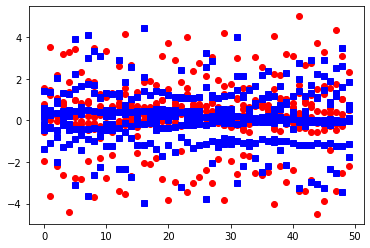

In [ ]:
# Plotagem de dados da matiz de característica das duas classes
plt.plot(matrix_carac[:][0:50], 'ro')
plt.plot(matrix_carac[:][50:100], 'bs')
plt.show()

In [ ]:
# K-Fold completo com as 10 interações
all_accuracy = []
for p in range(10):
  e = randint(10,100)
  b = e - 10

  # Matriz de distancia entre todos os sinais selecionados aos sinais que 
  # ficaram fora do grupo selecionado no K-Fold em relação as características
  dist_matrix = []
  distance_new = []
  data_1 = matrix_carac[b:e]
  for z in range(10):
    dist_line = []
    for x in range(0,100):
      if x < b or x >= e:
        data_2 = matrix_carac[x]
        # Distância euclidiana de cada sinal selecionado aos outros sinais não
        # selecionados
        distance_new = euclideanDistance(data_1[z], data_2, 7) 
        dist_line += [distance_new]
    dist_matrix += [dist_line]

  # Criando array de 3 vizinhos mais próximos baseados na distância euclidiana
  min_values_matrix = []
  for i in range(10):
    list_min_values = []
    list_min_values = sorted(dist_matrix[i])[0:3]
    min_values_matrix.append(list_min_values)

  # Selecionando os índices dos 3 sinais de menores distância a cada sinal
  # selecionado pelo grupo do K-Fold. Comparando os índices da tabela original,
  # a partir dos valores obtidos, e os valores obtidos anteriormente
  indices_n = []
  all_distances = []
  for z in range(10):
    for x in range(0,100):
        data_2 = matrix_carac[x]
        distance_new_n = euclideanDistance(data_1[z], data_2, 7)
        all_distances.append(distance_new_n)
    list_for_indices = []
    for j in range(3):
        list_for_indices += [i for i, k in enumerate(all_distances) if k == min_values_matrix[z][j]]
    indices_n += [list_for_indices]
    all_distances = []

  # Guardando os labels (classes) dos vizinhos mais próximos encontrados
  labels_n = []
  for i in range(10):
    list_labels = []
    for j in indices_n[i]:
      list_labels += [both_classes_n[j]['label']]
    labels_n += [list_labels]

  # Obtendo label mais frequente dentre os 3 mais próximos
  # e classificando como label dos sinais escolhidos
  import statistics as stc
  list_indices_classified = []
  for i in range(10):
    aux = labels_n[i]
    aux2 = stc.mode(aux)
    list_indices_classified.append(aux2)

  # Teste de acurácia com labels corretos e labels previstos (classificados)
  testSet_n = both_classes_n[b:e]
  predictions_n = list_indices_classified
  accuracy_n = getAccuracy(testSet_n, predictions_n)
  all_accuracy.append(accuracy_n)
  
print(f'Média das acurácias: {int(np.mean(all_accuracy))}%')

Média das acurácias: 100%


## **Aplicando Nearest Prototype Classifier com K-Fold (K = 10) todas as interações e média de acuácia**

In [ ]:
# Aquisição de características dos sinais
matrix_carac = []
vet_linha_carac_orig = []
for i in range(100):
  line_aux = []
  vet_linha_carac = []
  for j in range(500):
    line_aux.append(both_classes[i][j])

  # Média
  m = np.mean(line_aux)
  vet_linha_carac.append(m)
  # Variância
  v = np.var(line_aux)
  vet_linha_carac.append(v)
  # Mínimo
  minm = np.min(line_aux)
  vet_linha_carac.append(minm)
  # Máximo
  maxm = np.max(line_aux)
  vet_linha_carac.append(maxm)
  # Desvio Padrão
  de = np.std(line_aux)
  vet_linha_carac.append(de)
  # Curtose
  kur = kurtosis(line_aux)
  vet_linha_carac.append(kur)
  # Assimetria
  sk = skew(line_aux)
  vet_linha_carac.append(sk)

  matrix_carac += [vet_linha_carac]

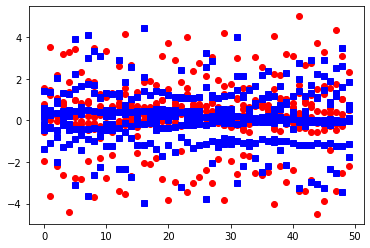

In [ ]:
# Plotagem de dados da matiz de característica das duas classes
plt.plot(matrix_carac[:][0:50], 'ro')
plt.plot(matrix_carac[:][50:100], 'bs')
plt.show()

Nota: É possível observar que as características adquiridas para esse método são as mesmas adotadas no método anterior (KNN)

In [ ]:
# Obtendo dados médios das duas classes baseados nas características adquiridas
mc1 = (matrix_carac[:][0:50])
mc2 = (matrix_carac[:][50:100])
matrix_mean_1 = []
matrix_mean_2 = []
for i in range(7):
  vet_carac1 = []
  vet_carac2 = []
  for j in range(50):
    vet_carac1.append(mc1[j][i])
    vet_carac2.append(mc2[j][i])

  matrix_mean_1.append(np.mean(vet_carac1))
  matrix_mean_2.append(np.mean(vet_carac2))

In [ ]:
# K-Fold completo com as 10 interações
all_accuracy = []
for p in range(10):
  # Seleção de grupo para teste e classificação
  e = randint(10,100)
  b = e - 10
  data_a = matrix_carac[b:e]

  # Obtenção dos labels para os dados escolhidos a partir da classificação em
  # relação a distância central das classes 1 e 2. A menor distância classifica
  # com o label da sua classe o sinal que está sendo classificado
  list_labels_classified = []
  for z in range(10):
    distance_prov1 = euclideanDistance(data_a[z], matrix_mean_1, 7)
    distance_prov2 = euclideanDistance(data_a[z], matrix_mean_2, 7)
    if distance_prov1 <= distance_prov2:
      list_labels_classified.append(1)
    else:
      list_labels_classified.append(2)

  # Obtenção dos índices reais dos sinais de teste
  indices_prov = []
  for i in range(10):
    indices_prov.append(b+i)

  # Obtenção dos labels reais dos sinais de teste
  labels_reals = []
  for j in indices_prov:
    labels_reals.append(both_classes_n[j]['label'])

  # Teste de acurácia com labels corretos e labels previstos (classificados)
  testSet_n = both_classes_n[b:e]
  predictions_n = list_labels_classified
  accuracy_n = getAccuracy(testSet_n, predictions_n)
  all_accuracy.append(accuracy_n)
  
print(f'Média das acurácias: {int(np.mean(all_accuracy))}%')

Média das acurácias: 81%
